In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

from nnwmf.optimize import IALM
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV
from nnwmf.utils import model_errors as merr

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

In [31]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/nnwmf"
zscore_filename = f"{data_dir}/GWAS_Zscore.tsv"
trait_filename = f"{data_dir}/trait_manifest_TableS6_no_readme.tsv"
zscore_df = pd.read_csv(zscore_filename, sep = '\t')
trait_df = pd.read_csv(trait_filename, sep = '\t')

# remove extra columns from trait_df

colnames = trait_df.columns.tolist()
colnames[0] = "zindex"
trait_df.columns = colnames
trait_df_mod = trait_df.drop(labels = ['coding', 'modifier', 'coding_description', 'filename', 'aws_link'], axis=1)
#trait_df_mod

In [3]:
#| code-fold: false

zscore_df

,rsid,z1,z2,z3,z4,z5,z6,z7,z8,z9,...,z2474,z2475,z2476,z2477,z2478,z2479,z2480,z2481,z2482,z2483
0,rs6657440,-0.903532,0.561842,0.711068,-0.109174,0.223668,-1.728199,0.374988,-0.265971,-2.823282,...,1.521092,0.612532,1.405428,0.018029,0.895337,-0.008761,-2.069432,-4.292948,-4.701711,2.952899
1,rs7418179,0.398166,1.163539,0.512118,0.144794,-1.313903,-1.547410,0.450270,0.560324,-1.502268,...,-0.296537,-0.734266,-0.093081,0.412077,1.961159,0.716049,-2.171984,-5.314085,-6.612137,3.817518
2,rs80125161,-1.739115,-0.172328,0.349145,-0.329335,-0.870640,-1.004155,1.128148,0.151244,-1.816075,...,2.222433,1.092969,2.328233,1.160767,0.909524,-1.467249,-0.135785,-2.187241,-3.223529,4.508578
3,rs7524174,-0.884478,-1.762000,1.312823,-0.550764,2.132540,0.519828,0.834194,0.699441,-0.885281,...,3.356354,1.990588,3.092179,-0.133810,-0.072845,-1.376310,1.317044,0.913491,0.535188,2.245657
4,rs3829740,-1.469931,-0.519628,-0.281605,-0.267729,-1.060167,0.058116,-0.638319,-0.589767,0.228514,...,-0.320075,-0.128047,-0.524757,-0.232900,-1.051020,-0.483644,2.026508,4.400092,5.407316,1.125536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51394,rs9616937,-0.211947,1.371231,-1.800776,0.609980,-0.619822,0.947269,-1.166021,0.478601,-0.359714,...,0.714167,0.354347,0.611158,-0.354725,1.073043,-0.831737,0.870924,1.432076,2.228501,0.536104
51395,rs1024374,0.027097,-1.817082,0.530216,0.813498,-0.076514,0.784427,1.411160,-1.111740,-0.224438,...,1.107098,1.482684,1.512723,0.322355,-0.374603,1.320194,-0.700092,-1.395039,-2.270186,0.360025
51396,rs144480800,0.545682,0.391830,0.520505,-1.280976,0.453876,-1.388940,0.025094,0.737788,1.178641,...,-0.562063,-1.148515,-0.994185,-0.268232,-0.069619,0.013256,-0.777667,-1.544760,-1.406344,2.205817
51397,rs5770994,1.441851,1.152368,-1.500000,-0.468137,-0.444156,-0.780139,-0.853550,-0.316097,0.311219,...,-1.185702,-0.624073,-0.859522,0.549669,1.809912,0.268733,0.947441,1.533302,1.658537,2.218653


In [7]:
# Randomly select 10000 rows and 500 columns
zscore_df_sampled = zscore_df.sample(n=10000, random_state = 42).sample(n=500, axis=1, random_state = 43)
zscore_df_sampled

,z1167,z281,z2357,z226,z743,z560,z2069,z2252,z1644,z491,...,z1779,z1669,z152,z131,z57,z2225,z2470,z106,z474,z1160
21135,1.747967,0.333150,-0.256725,1.101227,1.877049,0.653582,2.184874,0.649850,0.624629,-0.568762,...,-0.196378,-1.007667,0.916585,0.108240,0.540421,-1.211147,-0.751328,0.078602,0.253098,0.203668
36838,-0.156658,-0.492547,-1.998114,-1.086678,0.063518,-1.942668,0.305734,-0.919531,-0.581345,-0.129932,...,1.889727,-0.108175,-1.346732,-0.801298,1.277992,4.373343,1.351446,-0.520159,-1.190272,0.731311
26302,-0.370480,-1.051778,-0.267559,1.269372,-0.370917,0.783508,1.393201,-1.027494,0.439653,0.497404,...,-0.619194,0.688585,-0.695459,-0.783111,-0.642857,4.030124,0.826335,1.014103,1.701609,0.433085
35137,-0.191911,0.976049,0.432594,0.988569,0.771049,-1.526316,-1.123623,-0.723978,0.883248,0.618741,...,0.493395,-0.514462,-0.225855,0.797255,-0.076689,0.757935,3.851805,-1.726221,-0.194140,0.040497
25047,2.262365,-1.031990,-0.402558,2.940195,0.545873,1.604303,-1.530728,-2.784586,-1.262213,-0.455971,...,-0.752998,-0.380618,-0.508555,1.104593,0.556324,0.495699,0.744503,1.554382,-0.383324,1.121189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44074,-0.262920,-1.041327,1.641563,-0.402090,-1.077609,-0.489245,0.953831,-0.653117,-1.914530,0.216378,...,0.682033,0.072718,-1.416000,1.450482,-0.228025,0.266796,-4.409254,1.349206,-0.533561,0.779899
28935,0.162851,1.425620,0.522926,-1.351447,0.141509,0.261944,1.089231,1.451613,2.439355,-0.309807,...,0.336451,1.515305,0.101981,0.770801,0.810334,6.099345,0.834298,-0.259695,0.294474,-1.023478
25329,-0.195354,-0.523103,1.113656,0.072485,1.593814,-1.990619,-0.359724,-0.447374,1.534896,-0.686970,...,0.081670,-1.757484,0.149871,-0.367180,-1.817944,3.461449,0.462327,1.543165,-0.364580,0.585727
22955,1.236731,1.064055,-0.461035,-0.702339,-1.697798,2.532889,-0.161650,-0.642910,0.868244,-0.398903,...,1.495010,1.105210,-0.106106,1.004655,-1.210867,-1.722286,2.081974,-0.419449,-0.989933,-0.221453


In [8]:
X = np.array(zscore_df_sampled.loc[:, zscore_df_sampled.columns!='rsid']).T
X_cent = X - np.mean(X, axis = 0, keepdims = True)

print (f"We have {X_cent.shape[0]} samples (phenotypes) and {X_cent.shape[1]} features (variants)")
print (f"Fraction of Nan entries: {np.sum(np.isnan(X)) / np.prod(X_cent.shape):.3f}")

We have 500 samples (phenotypes) and 10000 features (variants)
Fraction of Nan entries: 0.000


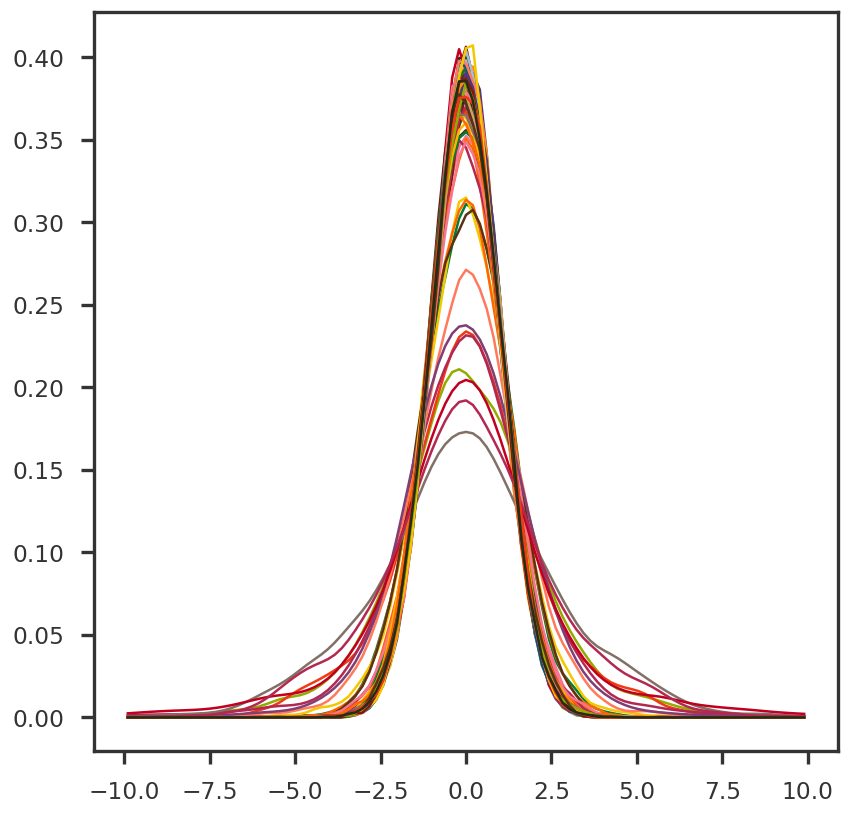

In [12]:
import scipy.stats as sc_stats

def get_density(x, data):
    density = sc_stats.gaussian_kde(data)
    return density.pdf(x)

def get_bins(data, nbin, xmin, xmax):
    xdelta = (np.max(data) - np.min(data)) / 10
    if not xmin: xmin = np.min(data) - xdelta
    if not xmax: xmax = np.max(data) + xdelta
    bins = np.linspace(xmin, xmax, nbin)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    return xmin, xmax, bins, xbin

fig = plt.figure()
ax1 = fig.add_subplot(111)

for n in range(100):
    scores_cent = X_cent[n, :]
    xmin, xmax, bins, xbin = get_bins(scores_cent, 100, -10, 10)
    curve = get_density(xbin, scores_cent)
    ax1.plot(xbin, curve)

plt.show()

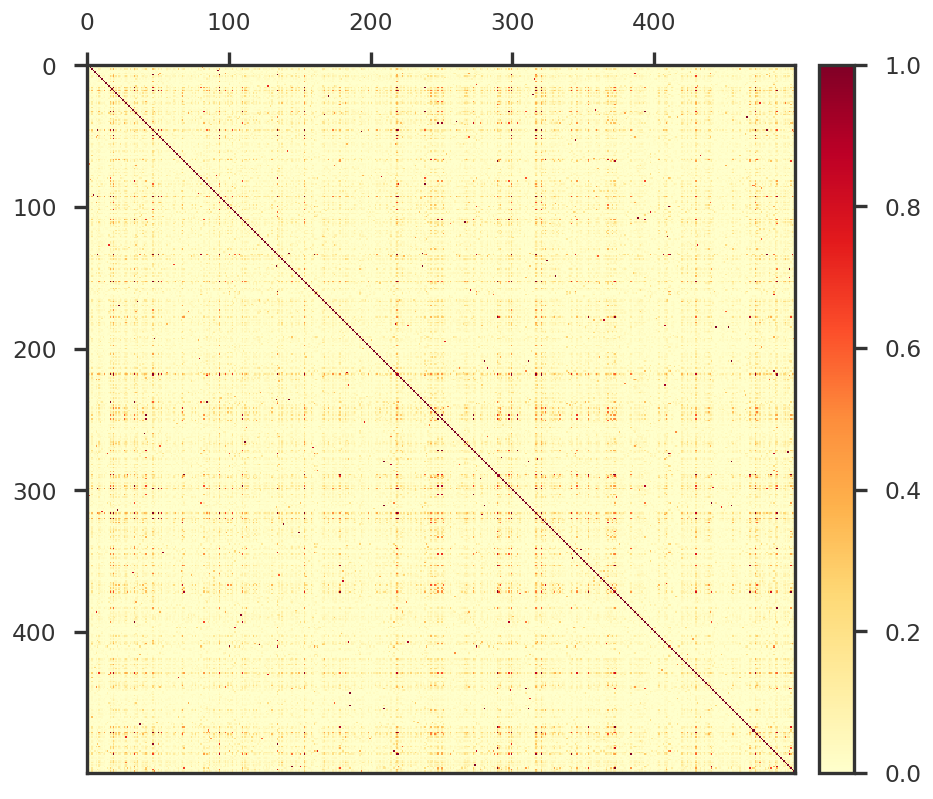

In [13]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)
                                            
#mpy_plotfn.plot_covariance_heatmap(ax1, Z * np.sqrt(p) / np.sqrt(nsample))
mpy_plotfn.plot_covariance_heatmap(ax1, X)

plt.tight_layout()
plt.show()

## Generate a masked input

In [28]:
def generate_masked_input(Y, mask):
    Ymiss_nan = Y.copy()
    Ymiss_nan[mask] = np.nan
    Ymiss_nan_cent = Ymiss_nan - np.nanmean(Ymiss_nan, axis = 0, keepdims = True)
    Ymiss_nan_cent[mask] = 0.0
    return Ymiss_nan_cent

def generate_mask(n, p, ratio):
    mask = np.ones(n * p)
    nzero = int(ratio * n * p)
    mask[:nzero] = 0.0
    np.random.shuffle(mask)
    return mask.reshape(n,p) == 0.

Z_mask = generate_mask(X.shape[0], X.shape[1], 0.33)
Z_cent = generate_masked_input(X_cent, Z_mask)

# RPCA - IALM

In [30]:
rpca_model = IALM(max_iter = 10000, mu_update_method='admm', show_progress = True, print_skip = 100)
rpca_model.fit(Z_cent, mask = Z_mask)

2024-01-25 11:07:24,343 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0100)
2024-01-25 11:07:28,138 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 0. Primal residual 0.93304. Dual residual 0.000634665
2024-01-25 11:09:38,433 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 100. Primal residual 3.55313e-05. Dual residual 2.52641e-05
2024-01-25 11:11:45,201 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 200. Primal residual 1.35185e-06. Dual residual 1.67434e-07
2024-01-25 11:13:38,758 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 300. Primal residual 1.15983e-07. Dual residual 5.06854e-09


In [38]:
print ("Nuclear Norms")
print (f"Original matrix: {np.linalg.norm(X, 'nuc')}")
print (f"Original matrix centered: {np.linalg.norm(X_cent, 'nuc')}")
print (f"Masked matrix: {np.linalg.norm(Z_cent, 'nuc')}")
print (f"Recovered matrix: {np.linalg.norm(rpca_model.L_, 'nuc')}")

Nuclear Norms
Original matrix: 52423.427148511015
Original matrix centered: 52187.88001747598
Masked matrix: 44964.11106526066
Recovered matrix: 1.770598736794419e-07


# NNM

In [39]:
rank_opt = 1024.
nnm_model = FrankWolfe(model = 'nnm', max_iter = 10000, svd_max_iter = 50, show_progress = True)
nnm_model.fit(Z_cent, rank_opt, mask = Z_mask)

2024-01-25 11:18:55,988 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 0.468. Duality Gap 490848


# NNM-Sparse

In [40]:
nnm_sparse_model = FrankWolfe(model = 'nnm-sparse', max_iter = 10000, svd_max_iter = 50, show_progress = True)
nnm_sparse_model.fit(Z_cent, (rank_opt, 0.5), mask = Z_mask)

2024-01-25 11:22:28,201 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 0.468. Duality Gap 491221


In [43]:
print ("Nuclear Norms")
print (f"Recovered matrix (NNM): {np.linalg.norm(nnm_model.X, 'nuc')}")
print (f"Recovered matrix (NNM-Sparse): {np.linalg.norm(nnm_sparse_model.X, 'nuc')}")

Nuclear Norms
Recovered matrix (NNM): 1015.0879690877024
Recovered matrix (NNM-Sparse): 1014.317846484247


In [46]:
from scipy.spatial import procrustes

def mean_squared_error(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    n = np.sum(mask)
    mse = np.sum(np.square((original - recovered) * mask)) / n
    return mse


def peak_signal_to_noise_ratio(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    omax = np.max(original[mask == 1])
    omin = np.min(original[mask == 1])
    maxsig2 = np.square(omax - omin)
    mse = mean_squared_error(original, recovered, mask)
    res = 10 * np.log10(maxsig2 / mse)
    return res


def matrix_dissimilarity_scores(original, recovered, mask = None):
    '''
    Procrustes analysis returns the square of the Frobenius norm.
    Use the rotated matrix to obtain the peak signal-to-noise ratio (PSNR).
    '''
    k = min(original.shape[1], recovered.shape[1])
    R_orig, R_recv, m2 = procrustes(original[:, 0:k], recovered[:, 0:k])
    psnr = peak_signal_to_noise_ratio(R_orig, R_recv, mask)
    rmse = np.sqrt(mean_squared_error(R_orig, R_recv, mask))
    return rmse, psnr

print ("RMSE")
orig_rmse, orig_psnr = matrix_dissimilarity_scores(X_cent, Z_cent, Z_mask)
rpca_rmse, rpca_psnr = matrix_dissimilarity_scores(X_cent, rpca_model.L_, Z_mask)
nnm_rmse, nnm_psnr = matrix_dissimilarity_scores(X_cent, nnm_model.X, Z_mask)
nnm_sparse_rmse, nnm_sparse_psnr = matrix_dissimilarity_scores(X_cent, nnm_sparse_model.X, Z_mask)

print (f"Original: {orig_rmse:g}")
print (f"RPCA: {rpca_rmse:g}")
print (f"NNM: {nnm_rmse:g}")
print (f"NNM-Sparse: {nnm_sparse_rmse:g}")

RMSE
Original: 8.9478e-05
RPCA: 0.000446309
NNM: 0.000407213
NNM-Sparse: 0.000407142


In [52]:
print ("RMSE")
print (f"Zero prediction: {orig_rmse:g}")
print (f"RPCA: {rpca_rmse:g}")
print (f"NNM: {nnm_rmse:g}")
print (f"NNM-Sparse: {nnm_sparse_rmse:g}")
print("")
print ("PSNR")
print (f"Zero prediction: {orig_psnr:g}")
print (f"RPCA: {rpca_psnr:g}")
print (f"NNM: {nnm_psnr:g}")
print (f"NNM-Sparse: {nnm_sparse_psnr:g}")

RMSE
Zero prediction: 8.9478e-05
RPCA: 0.000446309
NNM: 0.000407213
NNM-Sparse: 0.000407142

PSNR
Zero prediction: 56.9045
RPCA: 42.9461
NNM: 43.7424
NNM-Sparse: 43.7439


In [49]:
zero_rmse, zero_psnr = matrix_dissimilarity_scores(X_cent, X, Z_mask)

RMSE


In [50]:
zero_rmse

3.859249487545338e-15

In [51]:
zero_psnr

264.2087877109133